# Temporal Convolution Net

_UNDER CONSTRUCTION_


- Vector Autoregression


In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import re
import time
from datetime import datetime
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from finds.plots import plot_bands
from finds.misc.show import Show
from finds.unstructured.store import Store
from secret import credentials, paths

# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
imgdir = paths['images'] / 'ts'
store = Store(paths['scratch'])
factors = store['approximate'].factors

__Vector Autoregression Model__

predict multiple time series (of the extracted approximate factors)


In [6]:
maxlags = 16
train_split = '2014-12-31'   # training period up to this date
test_split = '2019-12-31'    # split test period into two (due to COVID)
train_index = factors.index[factors.index <= train_split]
test1_index = factors.index[(factors.index >= train_index[-maxlags]) &
                            (factors.index <= test_split)]
test2_index = factors.index[(factors.index >= test1_index[-maxlags])]
test_end = max(test2_index).strftime('%Y-%m-%d')
train_data = factors.loc[train_index].copy()
test1_data = factors.loc[test1_index].copy()
test2_data = factors.loc[test2_index].copy()
M = train_data.shape[1]      # M is number of vectors to autoregress
model = VAR(train_data, freq='M')

__Auto Select Lag Order__

The lagged coefficients estimated from the Vector Autoregression produce a 
multi-period cumulative forecast 


In [7]:
show(DataFrame({ic: model.fit(maxlags=maxlags, ic=ic).k_ar
                for ic in ['aic', 'fpe', 'hqic', 'bic']},
               index=['optimal p:'])\
     .rename_axis(columns='IC:'),
     caption="Optimal number of VAR(p) lags selected by Information Criterion")


IC:,aic,fpe,hqic,bic
Optimal number of VAR(p) lags selected by Information Criterion,,,,
optimal p:,9,9,3,2


In [8]:
### Collect one-period ahead forecasts and errors in train and test sets
results = {p: model.fit(p) for p in range(1, maxlags+1)}   # VAR(p) models
from sklearn.metrics import mean_squared_error as mse
mean_error = dict()   # to collect unconditional mean error each month
var_error= {p: dict() for p in results}  # collect error each month for each p

In [9]:
for sample in [train_data, test1_data, test2_data]:  # loop over 3 subsamples
    
    for i in range(maxlags, len(sample)):  # start at maxlag'th obs
    
        # accumulate to error of unconditional mean forecast
        mean_error[sample.index[i]] = mse(sample.iloc[i].values,
                                          train_data.mean().values)
        
        # accumulate to error of VAR(p) model forecasts
        for p in var_error:

            # include p prior for VAR(p) to forecast i'th obs
            pred = results[p].forecast(sample.iloc[(i-p):i].values, 1)
            var_error[p][sample.index[i]] = mse([sample.iloc[i].values], pred)

In [10]:
# Collect mean test and train set errors of all VAR(p) models
errors = {0: Series(mean_error, name="TrainSampleMean")}  # VAR(0)
errors.update({p: Series(var_error[p], name=f"VAR({p})")
               for p in var_error})
out = [Series({'Train Error': e.loc[e.index <= train_split].mean(),
               'Test1 Error': e.loc[test1_index].mean(),
               'Test2 Error': e.loc[test2_index].mean()},
              name=e.name) for p, e in errors.items()]
out = pd.concat(out, axis=1).T.rename_axis(columns="1961-07-31...2019-12-31:")
out

1961-07-31...2019-12-31:,Train Error,Test1 Error,Test2 Error
TrainSampleMean,0.966422,0.475856,1.869434
VAR(1),0.657480,0.356948,1.955375
VAR(2),0.607881,0.329619,1.912644
VAR(3),0.582625,0.321119,1.935668
VAR(4),0.565950,0.321482,1.965509
VAR(5),0.550050,0.325775,2.050291
VAR(6),0.535415,0.326891,2.069849
VAR(7),0.520095,0.331472,2.094007
VAR(8),0.506079,0.325011,2.133762
VAR(9),0.490080,0.329260,2.037579


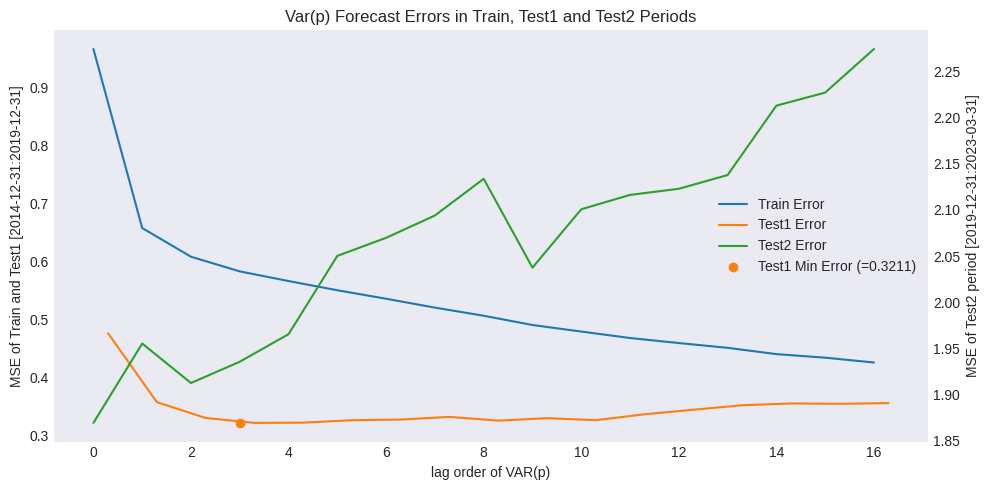

In [11]:
### Plot Train and Test Error of all VAR(p) Models
fig, ax = plt.subplots(1, 1, figsize=(10, 5), num=1, clear=True)
ax.plot(np.arange(len(out)), out['Train Error'], color="C0")
ax.plot(np.arange(len(out))+.3, out['Test1 Error'], color="C1")
ax.plot([], [], color="C2")   # dummy for legend labels
argmin = out['Test1 Error'].argmin()
ax.plot(argmin, out.iloc[argmin]['Test1 Error'], 'o', color="C1")
bx = ax.twinx()
bx.plot(np.arange(len(out)), out['Test2 Error'], color=f"C2")
ax.set_title(f'Var(p) Forecast Errors in Train, Test1 and Test2 Periods')
ax.set_ylabel(f'MSE of Train and Test1 [{train_split}:{test_split}]')
bx.set_ylabel(f'MSE of Test2 period [{test_split}:{test_end}]')
ax.set_xlabel('lag order of VAR(p)')
ax.legend(['Train Error', 'Test1 Error', 'Test2 Error',
           f'Test1 Min Error (={out.iloc[argmin]["Test1 Error"]:.4f})'],
          loc='center right')
plt.tight_layout()
plt.savefig(imgdir / 'varerr.jpg')

## Temporal Convolutional Net (TCN)


In [12]:
class TCN(torch.nn.Module):
    class CausalConv1dBlock(torch.nn.Module):
        """Conv1d block with ReLU, skip, dropout, dilation and padding"""
        def __init__(self, in_channels, out_channels, kernel_size, dilation,
                     dropout):
            super().__init__()

            print('kernel', kernel_size, 'dilation', dilation)
            self.network = torch.nn.Sequential(
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(in_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(out_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout))
            self.skip = lambda x: x
            if in_channels != out_channels:   # downsample for skip if necessary
                self.skip = torch.nn.Conv1d(in_channels, out_channels, 1)

        def forward(self, x):
            return self.network(x) + self.skip(x)  # with skip connection


    def __init__(self, n_features, blocks, kernel_size, dropout):
        """TCN model by connecting multiple convolution layers"""
        super().__init__()
        in_channels = n_features
        L = []
        for dilation, hidden in enumerate(blocks):
            L.append(self.CausalConv1dBlock(in_channels=in_channels,
                                            out_channels=hidden,
                                            kernel_size=kernel_size,
                                            dilation=2**dilation,
                                            dropout=dropout))
            in_channels = hidden
        self.network = torch.nn.Sequential(*L) if L else lambda x: x
        if L:
            self.classifier = torch.nn.Conv1d(in_channels, n_features, 1)
        else:
            self.classifier = torch.nn.Sequential(
                torch.nn.ConstantPad1d((kernel_size-1, 0), 0),                
                torch.nn.Conv1d(in_channels, n_features, kernel_size))

    def forward(self, x):
        """input is (B, n_features, L)), linear expects (B, * n_features)"""
        return self.classifier(self.network(x))

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

In [13]:
### Form input data from training set
seq_len = 16    # length of each input sequence for TCN
train_exs = [train_data.iloc[i-(seq_len+1):i].values
             for i in range(seq_len+1, len(train_data))]

In [14]:
### Fit TCN models with increasing layers of convolution and dropout rates
n_features = train_data.shape[1]    # number of input planes
batch_size = 8
step_size = 100      # learning rate scheduler step size
lr = 0.01            # initial learning rate
num_lr = 6
res = []             # to collect results summaries
tcn_error = dict()   # to store prediction errors

In [15]:
kernel_sizes = [1, 2, 4]
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
blocks = [0, 1, 2]
for block in blocks:
    for parm in (dropouts if block else kernel_sizes):
        if block:
            dropout = parm
            kernel_size = 3
        else:
            dropout = 0.0
            kernel_size = parm
        modelname = f"TCN{block}_{kernel_size}_{dropout*100:.0f}"

        # Set model, optimizer, loss function and learning rate scheduler
        model = TCN(n_features=n_features, blocks=[n_features]*block,
                    kernel_size=kernel_size, dropout=dropout).to(device)
        print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                    step_size=step_size)
        loss_function = nn.MSELoss()

        # Run training loop over num_epochs with batch_size
        num_epochs = step_size * num_lr
        for epoch in range(num_epochs):
            idxs = np.arange(len(train_exs))   # shuffle indxs into batches
            random.shuffle(idxs)
            batches = [idxs[i:(i+batch_size)]
                       for i in range(0, len(idxs), batch_size)]

            total_loss = 0.0               # train by batch
            model.train()
            for batch in batches:
                # input has shape (batch_size=8, n_features=8, seq_len=16)
                # Creating a tensor from a list of numpy.ndarrays is extremely
                # slow. Please consider converting the list to a single
                # numpy.ndarray with numpy.array() before converting to a tensor
                nparray = np.array([[train_exs[idx][seq] for idx in batch]
                                    for seq in range(seq_len+1)])
                train_ex = torch.tensor(nparray)\
                                .permute(1,2,0).float().to(device)
                model.zero_grad()
                X = train_ex[:,:,:-1]
                Y = train_ex[:,:,1:]
                output = model(X)
                loss = loss_function(output, Y)  # calculated over all outputs
                total_loss += float(loss)
                loss.backward()
                optimizer.step()
            scheduler.step()
            if VERBOSE and (epoch % (step_size//2)) == 0:
                print(epoch, num_epochs, block, dropout,
                      optimizer.param_groups[0]['lr'], total_loss/len(batches))
            model.eval()

        # Compute MSE of one-period ahead forecast error in train and test sets
        e = dict()
        for x in [train_data, test1_data, test2_data]:
            for i in range(seq_len, len(x)):
                X = torch.tensor(x.iloc[(i-seq_len):i].values.T)\
                         .unsqueeze(0).float().to(device)
                pred = model(X)
                e[x.index[i]] = mse([x.iloc[i].values],
                                    pred[:,:,-1].cpu().detach().numpy())
        model.save(imgdir / (modelname + '.pt'))
        e = Series(e, name=modelname)
        tcn_error[modelname] = e
        res.append(Series({
            'blocks': block, 'dropout': dropout, 'kernel_size': kernel_size,
            'Train Error': float(e[e.index <= train_split].mean()),
            'Test1 Error': float(e[test1_index].mean()),
            'Test2 Error': float(e[test2_index].mean())}, name=modelname))
        #print(pd.concat(res, axis=1).T)
res = pd.concat(res, axis=1).T.astype({'blocks': int, 'kernel_size': int})
res

TCN(
  (classifier): Sequential(
    (0): ConstantPad1d(padding=(0, 0), value=0)
    (1): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  )
)
TCN(
  (classifier): Sequential(
    (0): ConstantPad1d(padding=(1, 0), value=0)
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  )
)
TCN(
  (classifier): Sequential(
    (0): ConstantPad1d(padding=(3, 0), value=0)
    (1): Conv1d(8, 8, kernel_size=(4,), stride=(1,))
  )
)
kernel 3 dilation 1
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 8, kernel_size=(3,), stride=(1,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(8, 8, kernel_size=(3,), stride=(1,))
        (5): ReLU()
        (6): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (classifier): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
)
kernel 3 dilation 1
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network

,blocks,dropout,kernel_size,Train Error,Test1 Error,Test2 Error
TCN0_1_0,0,0.0,1,0.657199,0.358790,1.960907
TCN0_2_0,0,0.0,2,0.609275,0.330528,1.906794
TCN0_4_0,0,0.0,4,0.572158,0.321935,1.956305
TCN1_3_0,1,0.0,3,0.420763,0.390504,1.798904
TCN1_3_10,1,0.1,3,0.446327,0.384417,2.004865
TCN1_3_20,1,0.2,3,0.476245,0.419338,2.024344
TCN1_3_30,1,0.3,3,0.492200,0.391346,2.291207
TCN1_3_40,1,0.4,3,0.519895,0.368835,1.940071
TCN1_3_50,1,0.5,3,0.544130,0.362974,1.971947
TCN2_3_0,2,0.0,3,0.336047,0.411147,2.053564


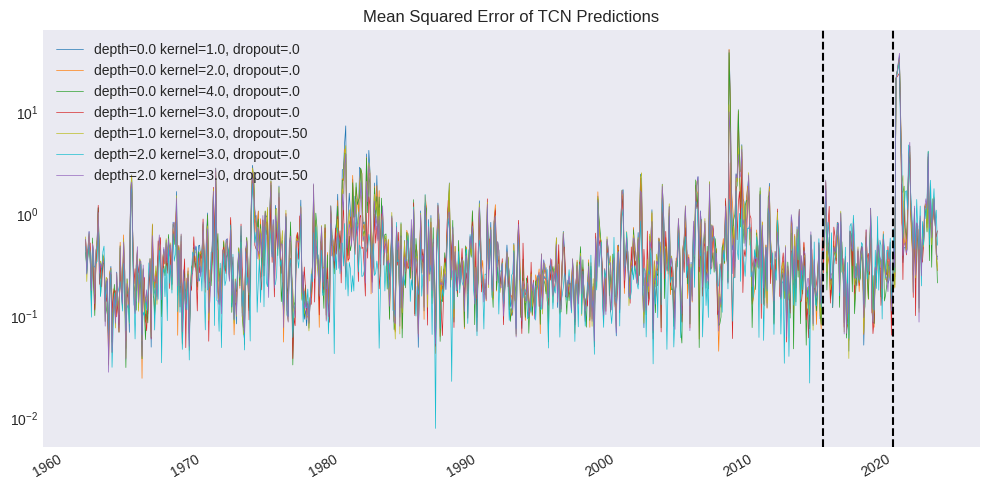

In [16]:
### Plot monthly mean squarejd error
fig, ax = plt.subplots(1, 1, figsize=(10, 5), num=1, clear=True)
ax.set_yscale('log')
legend = []
for col, (modelname, parm) in enumerate(res.iterrows()):
    if parm.dropout in [0.0, 0.5]:
        tcn_error[modelname].plot(ax=ax, c=f'C{col}', lw=.5, ls='-')
        legend.append(f"depth={parm.blocks} kernel={parm.kernel_size}, "
                      f"dropout=.{100*parm.dropout:.0f}")
#for a,b in vspans:
#    if a >= train_index[maxlags]:
#        ax.axvspan(a, min(b, max(test2_index)), alpha=0.3, color='grey')
ax.set_title('Mean Squared Error of TCN Predictions')
ax.axvline(max(train_index), color='black', linestyle='--')
ax.axvline(max(test1_index), color='black', linestyle='--')
ax.legend(legend, loc='upper left')
plt.tight_layout()
plt.savefig(imgdir / 'tcnmse.jpg')

In [17]:
### Display train and test error of TCN models by dropout parameters
res[res['blocks'].gt(0)]\
    .rename(columns={s+' Error': s for s in ['Train','Test1','Test2']})\
    .pivot(index=['dropout'], columns=['blocks'])\
    .drop(columns=['kernel_size'])\
    .swaplevel(0, 1, 1).round(4).sort_index(axis=1)

blocks        1                       2                
          Test1   Test2   Train   Test1   Test2   Train
dropout                                                
0.0      0.3905  1.7989  0.4208  0.4111  2.0536  0.3360
0.1      0.3844  2.0049  0.4463  0.3944  2.2132  0.4121
0.2      0.4193  2.0243  0.4762  0.3889  2.0885  0.4050
0.3      0.3913  2.2912  0.4922  0.3850  2.1908  0.4528
0.4      0.3688  1.9401  0.5199  0.3786  2.0730  0.4685
0.5      0.3630  1.9719  0.5441  0.3799  2.0363  0.5144

In [18]:
### Display train and test error of TCN models by size parameters
res[res['blocks'].eq(0)]\
    .rename(columns={s+' Error': s for s in ['Train','Test1','Test2']})\
    .pivot(index=['kernel_size'], columns=['blocks'])\
    .drop(columns=['dropout'])\
    .swaplevel(0, 1, 1).round(4).sort_index(axis=1)

blocks            0                
              Test1   Test2   Train
kernel_size                        
1            0.3588  1.9609  0.6572
2            0.3305  1.9068  0.6093
4            0.3219  1.9563  0.5722

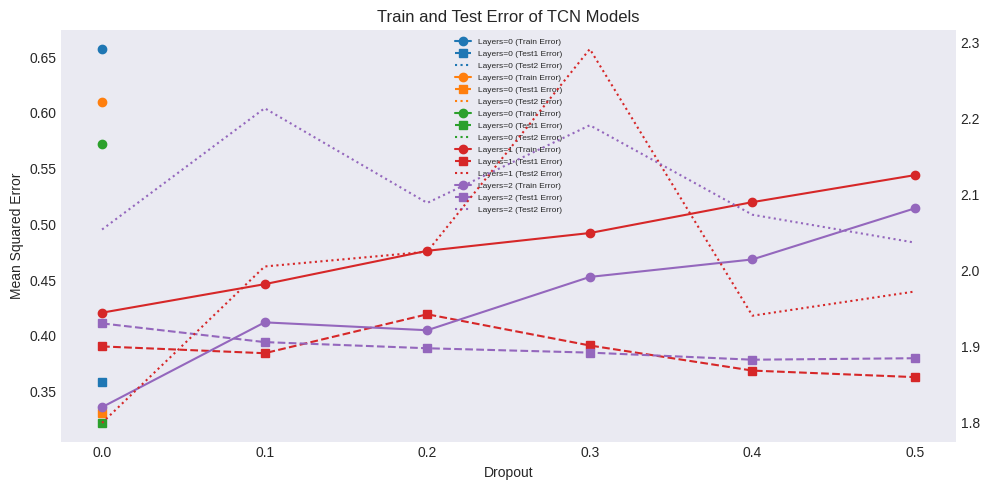

In [19]:
### Plot Train and Test Error of TCN Models
fig, ax = plt.subplots(1, 1, figsize=(10, 5), num=1, clear=True)
bx = ax.twinx()
col = 0
for block in np.unique(res.blocks):
    select_block = res['blocks'].eq(block)
    for kernel_size in np.unique(res['kernel_size'][select_block]):
        select = res['blocks'].eq(block) & res['kernel_size'].eq(kernel_size)

        Series(index=res['dropout'][select], 
               data=res['Train Error'][select].values,
               name=f"Layers={block:.0f} (Train Error)")\
               .plot(ax=ax, color=f"C{col}", style='-', marker='o')
        Series(index=res['dropout'][select], 
               data=res['Test1 Error'][select].values,
               name=f"Layers={block:.0f} (Test1 Error)")\
               .plot(ax=ax, color=f"C{col}", style='--', marker='s')
        ax.plot([],[], color=f"C{col}", ls=':',
                label=f"Layers={block:.0f} (Test2 Error)")
        Series(index=res['dropout'][select], 
               data=res['Test2 Error'][select].values)\
               .plot(ax=bx, color=f"C{col}", style=':')
        col = col + 1    
ax.set_title('Train and Test Error of TCN Models')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Dropout')
ax.legend(loc='upper center', fontsize=6)
plt.tight_layout()
plt.savefig(imgdir / 'tcn.jpg')